In [115]:
import torch
import torch.nn.functional as F
from torch import nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

In [116]:
import time
from sklearn.manifold import TSNE
from tqdm import tqdm

In [117]:
import pickle
import json
import string

In [118]:
import urllib.request

In [119]:
url = "https://cs.stanford.edu/people/karpathy/char-rnn/warpeace_input.txt"

response = urllib.request.urlopen(url)
text = response.read().decode("utf-8")

In [120]:
%pip install nltk


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [121]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [122]:
# Preprocessing function
def preprocess_text(text):
    # Tokenize the text into words
    tokens = nltk.tokenize.word_tokenize(text.lower())
    # Remove punctuation and non-alphabetic tokens
    words = [word for word in tokens if word.isalpha()]
    return words

words = preprocess_text(text)

In [123]:
print(words[:10])

['well', 'prince', 'so', 'genoa', 'and', 'lucca', 'are', 'now', 'just', 'family']


In [124]:
# Create a vocabulary mapping
vocab = sorted(set(words))  
vocab += ['unknown token', 'padding']
vocab_size = len(vocab)
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
idx_to_word = {idx: word for idx, word in enumerate(vocab)}

In [125]:
# Step 2: Define the  Model
class RNNTextGenerator(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(RNNTextGenerator, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim,batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.rnn(x) 
        x = self.fc(x[:, -1, :])
        return x

In [ ]:
context_length = 5

# Step 3: Prepare training data
def prepare_data(words, context_length):
    X, y = [], []
    for i in range(context_length, len(words)):
        X.append([word_to_idx[word] for word in words[i-context_length:i]])
        y.append(word_to_idx[words[i]])
    return np.array(X), np.array(y)


X, y = prepare_data(words, context_length)
print(X.shape, y.shape)

In [108]:
# Step 4: Initialize the model, define the loss function and optimizer
embedding_dim = 64
hidden_dim = 128
model = RNNTextGenerator(vocab_size, embedding_dim, hidden_dim)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [109]:
import tensorflow as tf

In [110]:
epochs = 10
batch_size = 32
train_data = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.long), torch.tensor(y, dtype=torch.long))
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [111]:
# Build the MLP model
'''
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=context_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(vocab_size, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)
'''


"\nmodel = tf.keras.Sequential([\n    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=context_length),\n    tf.keras.layers.Flatten(),\n    tf.keras.layers.Dense(128, activation='relu'),\n    tf.keras.layers.Dense(vocab_size, activation='softmax')\n])\n\nmodel.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])\nmodel.summary()\n\n# Train the model\nhistory = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)\n"

In [112]:
# # Step 5: Train the model
# num_epochs = 20
# for epoch in range(num_epochs):
#     model.train()
#     optimizer.zero_grad()
#     outputs = model(X)
#     loss = criterion(outputs, y)
#     loss.backward()
#     optimizer.step()
    
#     if (epoch + 1) % 5 == 0:
#         print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

In [113]:
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

Epoch 1/10:  59%|█████▉    | 10315/17531 [06:08<04:17, 28.00it/s]


KeyboardInterrupt: 

In [92]:
# Step 6: Save the model and vocabulary using pickle
with open('rnn_text_generator.pkl', 'wb') as f:
    pickle.dump(model, f)


vocab_data = {
    "word_to_idx": word_to_idx,
    "idx_to_word": idx_to_word
}
with open('vocab.json', 'w') as f:
    json.dump(vocab_data, f)

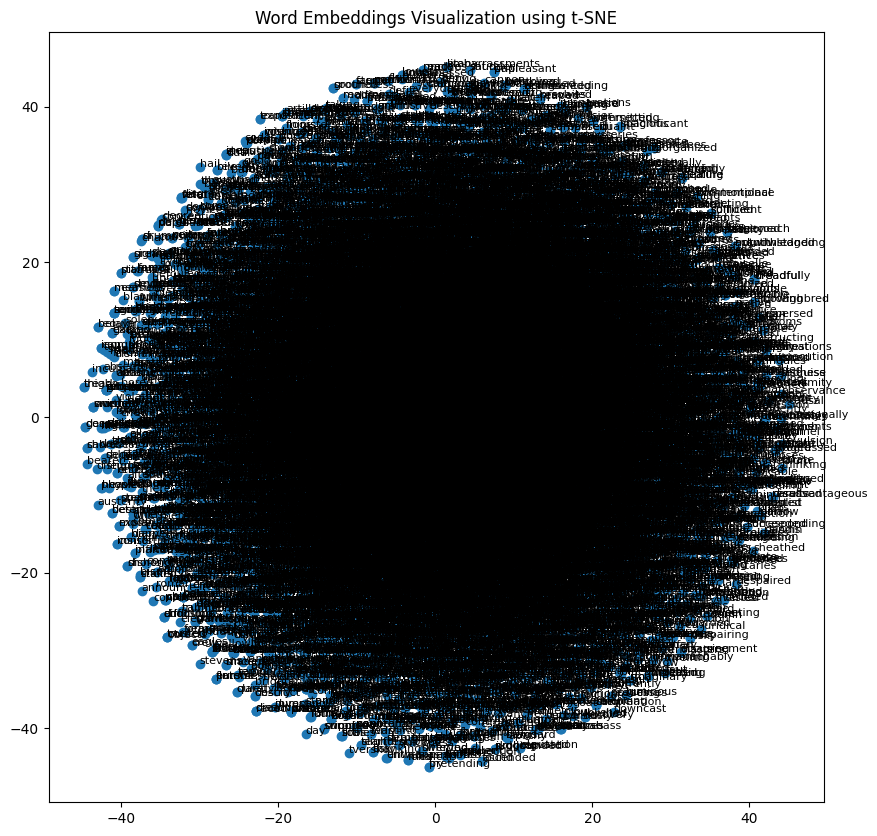

In [77]:
# Extract embeddings and visualize using t-SNE
embeddings = model.embedding.weight.detach().numpy()
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot t-SNE visualization
plt.figure(figsize=(10, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
for i, word in enumerate(vocab):
    plt.annotate(word, xy=(embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=8)
plt.title("Word Embeddings Visualization using t-SNE")
plt.show()

In [78]:
# Extract embeddings
'''embeddings = model.layers[0].get_weights()[0]

# Reduce dimensions for visualization
tsne = TSNE(n_components=2, random_state=seed)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot the t-SNE visualization
plt.figure(figsize=(10, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
for i, word in enumerate(vocab):
    plt.annotate(word, xy=(embeddings_2d[i, 0], embeddings_2d[i, 1]))
plt.title('Word Embeddings Visualization using t-SNE')
plt.show()'''

"embeddings = model.layers[0].get_weights()[0]\n\n# Reduce dimensions for visualization\ntsne = TSNE(n_components=2, random_state=seed)\nembeddings_2d = tsne.fit_transform(embeddings)\n\n# Plot the t-SNE visualization\nplt.figure(figsize=(10, 10))\nplt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])\nfor i, word in enumerate(vocab):\n    plt.annotate(word, xy=(embeddings_2d[i, 0], embeddings_2d[i, 1]))\nplt.title('Word Embeddings Visualization using t-SNE')\nplt.show()"

In [88]:
import torch
import pickle
import json   
import nltk

# Load model and vocabulary
with open('rnn_text_generator.pkl', 'rb') as f:
    model = pickle.load(f)

with open('vocab.json', 'r') as f:
    word_to_idx = json.load(f)

idx_to_word = {idx: word for word, idx in word_to_idx.items()}

# Function to predict the next word
def preprocess_text(sentence):
    tokens = nltk.tokenize.word_tokenize(sentence.lower())
    words = [word for word in tokens if word.isalpha()]
    return words

def predict_next_word(sentence, context_length=5):
    model.eval()
    words = preprocess_text(sentence)
    if len(words) < context_length:
        words = ['padding'] * (context_length - len(words)) + words
    
    input_indices = [word_to_idx[word] for word in words[-context_length:]]
    input_tensor = torch.tensor([input_indices], dtype=torch.long)

    with torch.no_grad():
        output = model(input_tensor)
        predicted_idx = output.argmax(dim=-1).item()
    return idx_to_word[predicted_idx]

# Test prediction
sentence = "I apologize on the behalf of "
print(f"The next word prediction for '{sentence}' : {predict_next_word(sentence)}")


The next word prediction for 'I apologize on the behalf of ' : stretcher


In [91]:
def predict_next_k_words(model, sentence, word_to_idx, idx_to_word, context_length=5, k=3):
    model.eval()
    words = preprocess_text(sentence)
    
    # If input sentence has fewer words than context_length, pad with start tokens
    if len(words) < context_length:
        words = ['padding'] * (context_length - len(words)) + words
    
    predicted_words = []
    
    for _ in range(k):
        # Prepare input for model
        input_indices = [word_to_idx.get(word, word_to_idx['unknown token']) for word in words[-context_length:]]
        input_tensor = torch.tensor([input_indices], dtype=torch.long)
        
        # Get model output and predicted word
        with torch.no_grad():
            output = model(input_tensor)
            predicted_idx = output.argmax(dim=-1).item()
            predicted_word = idx_to_word[predicted_idx]
        
        # Append prediction and update context
        predicted_words.append(predicted_word)
        words.append(predicted_word)  # Use the predicted word as the next input
    
    return predicted_words

# Example usage:
sentence = "As we have more registrations "
predicted_words = predict_next_k_words(model, sentence, word_to_idx, idx_to_word, context_length=5, k=3)
print(f"The next 3 words for '{sentence}' are: {' '.join(predicted_words)}")


The next 3 words for 'As we have more registrations ' are: than once he


In [93]:
vocab_size = len(word_to_idx)
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 17196
